In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Ge_calculation import GAP, MD_run
from mtp import *
from snap import *
from Ge_analysis import get_castep_E
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
from ase import build
from ase.atoms import Atoms
from quippy.potential import Potential
from quippy.descriptors import Descriptor
from copy import deepcopy
from ase.io.castep import read_castep_castep, read_param
import pandas as pd
from ase.lattice import hexagonal, tetragonal, orthorhombic
from ase.constraints import StrainFilter, UnitCellFilter, ExpCellFilter, FixAtoms
from ase.spacegroup.symmetrize import FixSymmetry
from ase.optimize import BFGS
from ase.data import covalent_radii, atomic_numbers
import warnings
from ase.spacegroup.symmetrize import check_symmetry

# Plan for this analysis package

Compare the EV and HP curves across potentials. Will need to find a way to use SNAP and MTPs with ASE, either as
calculators in their own right, but most likely via the lammps interface for the latter.

In [3]:
covalent_radii[atomic_numbers['Ge']]

1.2

In [4]:
class Cmca_factory(orthorhombic.BaseCenteredOrthorhombicFactory):
    xtal_name='Cmca'
    bravais_basis=[[0.717993, 0.282007, 0.5     ],
                  [0.217993, 0.782007, 0.      ],
                  [0.282007, 0.717993, 0.5     ],
                  [0.782007, 0.217993, 0.      ],
                  [0.331168, 0.331168, 0.829096],
                  [0.668832, 0.668832, 0.170904],
                  [0.168832, 0.168832, 0.329096],
                  [0.831168, 0.831168, 0.670904]]

class bSn_factory(tetragonal.CenteredTetragonalFactory):
    xtal_name='bSn'
    bravais_basis=[[0, 0.5, 0.25], [0.0, 0.0, 0.5]]

class Imma_factory(orthorhombic.BodyCenteredOrthorhombicFactory):
    xtal_name='Imma'
    bravais_basis=[[0.0641, 0.0000, 0.7500], [0.4359, 0.5000, 0.7500]]

class CrystTest:
    '''Centre for the analysis of crystal structure minima using ASE calculators

    Data is returned in a pandas DataFrame, indexed by the crystal structures
                        Default V   V           E           V           E
                Atoms   1st pot     1st pot     1st pot     2nd pot     2nd pot
    --------------------------------------------------------------------------
    fcc     .
    bcc     .
    diamond .
    .       .
    .       .
    .       .
    TODO:
        Automatic scaling of lattice parameter initial guesses using covalent radii
        Ability to add custom crystal structures
        Better error handling for unconverged geometries

        '''

    def __init__(self, pots, element,
                 extra_configs=[], extra_labels=[], n=10, opt=True, silent=False,
                 load=False, start_cells = {}, steps=100):
        '''pots: list of ase calculator objects (currently GAPs and MTPs). Strings will be
                    interpreted as GAP param_filenames
        element: element used for the pots (multicomponent systems not yet supported)
        extra_configs/labels: custom crystal structures for evaluation (see add_config method)
        n: number of V points calculated per crystal structure
        opt: bool, optimize the crystal structures? If a particular calculator is unstable, add this using
            add_pot()
        silent: bool, silence output

        '''
        if not isinstance(pots, list):
            self.pots = [pots]
        else:
            self.pots = pots
        if load: # awaiting implementation
            raise NotImplementedError('Hang tight, coming soon')

        for i in range(len(pots)):
            if not hasattr(pots[i], 'calculate'):
                # assume is the filename (str) of a GAP from typical analysis
                pots[i] = Potential(param_filename=pots[i])

        # Need a better way of guessing the initial latice parameters - e.g. scaling by atomic radius
        # based on True Si data
        e_r = covalent_radii[atomic_numbers[element]]
        Si_r = covalent_radii[14]

        bSn_fact = bSn_factory()
        bSn = Atoms(bSn_fact(symbol=element, latticeconstant={'a':5.2, 'c':2.87}))

        Imma_fact = Imma_factory()
        Imma = Imma_fact(symbol=element, latticeconstant={'a':2.87, 'b':4.99, 'c':5.30})

        structs = [build.bulk(element, crystalstructure='fcc', a=3.0, cubic=True),
                   build.bulk(element, crystalstructure='diamond', a=5.0,  cubic=True),
                   build.bulk(element, crystalstructure='hcp', a=3, c=5),
                   build.bulk(element, crystalstructure='bcc', a=3.0, cubic=True),
                   build.bulk(element, crystalstructure='sc', a=3.0),
                   Atoms(hexagonal.Hexagonal(symbol=element, latticeconstant={'a':3.0, 'c':3.0})),
                   bSn,
                   Imma] +\
            [deepcopy(i) for i in extra_configs]

        self.labels = ['fcc', 'dia', 'hcp', 'bcc', 'sc', 'sh', 'bSn', 'Imma'] + extra_labels
        self.opt_structs = []

        # Optimise the unit cell vectors if required
        cells = [[] for i in range(len(pots))]
        for j, pot in enumerate(self.pots):
            copy_structs = deepcopy(structs)
            for ct, val in enumerate(copy_structs):
                if opt:
                    val.set_calculator(pot)
                    uf = StrainFilter(val) # should ensure only the lattice can move, not atomic positions
                    opt = BFGS(uf, logfile='/dev/null')
                    opt.run(0.05, steps=steps)
                    if not opt.converged():
                        warnings.warn(('Warning: pot \'{}\' failed to converge on structure {}\n' +\
                                      'in {} steps').format(pot.name, val, steps))
                        val.set_cell(np.NaN*np.ones(3)) # flag unconverged geometry
                    val.set_calculator(None)
                cells[j].append(val.get_cell())
                if j == 0:
                    self.opt_structs.append(val)
        if not silent:
            print('opts done')

        # Evaluate the E/V curves on the optimised cells
        E = [[[] for j in range(len(structs))] for i in range(len(pots))]
        V = [[[] for j in range(len(structs))] for i in range(len(pots))]
        for j, pot in enumerate(self.pots):
            copy_structs = deepcopy(structs)
            for ct, val in enumerate(copy_structs):
                for i in np.linspace(0.95, 1.05, n):
                    val.set_cell(i*cells[j][ct], scale_atoms=True)
                    val.set_calculator(pot)
                    E[j][ct].append(val.get_potential_energy()/len(val))
                    V[j][ct].append(val.get_volume()/len(val))

            if not silent:
                print('pot {0} done'.format(pot.name))

        # Construct a DataFrame with the data
        dat = {'Structure':structs, 'Volumes':V[0]}
        for i, val in enumerate(self.pots):
            dat.update({val.name +  '_V' : V[i], val.name + '_E' : E[i]})
        print(dat)
        self.df = pd.DataFrame(dat, index=self.labels)

    def add_config(self, config, label, opt=False, n=10):

        config = deepcopy(config)
        if opt:
            config.set_calculator(self.pots[0])
            uf = UnitCellFilter(config)
            opt = BFGS(uf, logfile='dump')
            opt.run(0.05)
            config.set_calculator(None)
        cell = config.get_cell()

        E = [[] for i in self.pots]; V = []
        for j, p in enumerate(self.pots):
            for i in np.linspace(0.95, 1.05, n):
                config.set_cell(i*cell)
                config.set_calculator(p)
                E[j].append(config.get_potential_energy()/len(config))
                if j == 0:
                    V.append(config.get_volume()/len(config))
            print('pot {0} done'.format(p.name))

        dat = {'Structure':[config], 'Volumes':[V]}
        for i, val in enumerate(self.pots):
            dat.update({val.name:[E[i]]})
        tdf = pd.DataFrame(dat, index=[label])
        self.df = self.df.append(tdf)

    def add_config_by_mpid(self):
        return

    def calc_HP(self, ps, pf, pn, opt_freq=4, subset=slice(0, 8, None)):
        '''Calculates the Enthalpy/Pressure curves for the structures.
        ps: float Starting pressure / GPa
        pf: float Final pressure
        pn: int number of pressure points
        opt_freq: how often is the geom reoptimised w.r.t. pressure points
        subset: slice which crystal structures to include'''


        p = np.linspace(ps, pf, pn)
        pea = p*0.05/8
        copy_structs = deepcopy(self.df['Structure'][subset])
        # consider initializing below as NaNs for pandas
        v = [[np.zeros(pn) for i in range(len(self.df))] for j in range(len(self.pots))]
        H = [[np.zeros(pn) for i in range(len(self.df))] for j in range(len(self.pots))]
        for j, pot in enumerate(self.pots):
            for ct, val in enumerate(copy_structs):
                val.set_calculator(pot)
                for i in range(len(p)):
                    if i % opt_freq == 0:
                        #val.set_constraint(FixAtoms(mask=[True for atom in val]))
                        #uf = ExpCellFilter(val, scalar_pressure=pea[i], hydrostatic_strain=True)
                        uf = ExpCellFilter(val, scalar_pressure=pea[i], hydrostatic_strain=True)
                        opt = BFGS(uf, logfile='/dev/null')
                        opt.run(0.05, steps=20)
                        if not opt.converged():
                            warnings.warn('Warning: {} did not converge at pressure {}'.format(
                                            self.labels[ct],p[i]))
                    v[j][ct][i] = (vt := val.get_volume()/len(val))
                    H[j][ct][i] = val.get_potential_energy()/len(val) + pea[i]*vt
                print('struct {} done'.format(self.df.index[ct]))

            print('\npot {0} done\n'.format(pot.name))
            self.df['H(P) {}'.format(pot.name)] = H[j]
        self.df['P'] = [p for i in range(len(self.df))]

        return

    def save(self, outfile):
        for i in flatten(self.df['Structure']):
            i.calc = None
        f = open(outfile, 'wb')
        pickle.dump(self.df, f)
        f.close()

    def load(self, infile):
        f = open(infile, 'rb')
        self.df = pickle.load(f)


    def add_pot(self, pot, opt=True, steps=100, n=10):

        if not hasattr(pot, 'calculate'):
            # assume is the filename (str) of a GAP from typical analysis
            print('Interpreting {} as a GAP'.format(pot))
            pot = Potential(param_filename=pot)
            pot.name = os.path.splitext(os.path.basename(pot))[0]

        self.pots.append(pot)
        cells = []

        if opt:
            copy_structs = deepcopy(self.df['Structure'])
            for ct, val in enumerate(copy_structs):
                if opt and ct < 8:
                    val.set_calculator(pot)
                    uf = StrainFilter(val)
                    opt = BFGS(uf, logfile='/dev/null')
                    opt.run(0.05, steps=steps)
                    if not opt.converged():
                        warnings.warn(('Warning: pot \'{}\' failed to converge on structure {}\n' +\
                                      'in {} steps').format(pot.name, val, steps))
                    val.set_calculator(None)
                cells.append(val.get_cell())
        else:
            cells = [i.get_cell() for i in self.opt_structs]

        E = [[] for j in range(len(self.df['Structure']))]
        V = [[] for j in range(len(self.df['Structure']))]
        copy_structs = deepcopy(self.df['Structure'])
        for ct, val in enumerate(copy_structs):
            val.set_calculator(pot)
            for i in np.linspace(0.95, 1.05, n):
                val.set_cell(i*cells[ct], scale_atoms=True)
                E[ct].append(val.get_potential_energy()/len(val))
                V[ct].append(val.get_volume()/len(val))

        self.df = self.df.join(pd.DataFrame({pot.name+'_V':V, pot.name+'_E':E}, index=self.labels))



    def plot_EV(self):
        return

In [5]:
DFT_struct = []
DFT_struct_labels = ['', '', '', '', '', '', '', '', '', 'diamond']
DFT_dir = '/home/joe/Documents/Ge_od/Structure_databases/crystals/Si_MP_dense_cryst'
for i in os.listdir(DFT_dir):
    if '.castep' in i:
        DFT_struct.append(read_castep_castep(os.path.join(DFT_dir, i))[0])
        DFT_struct[-1].info['energy'] = get_castep_E(os.path.join(DFT_dir, i))

In [6]:
for i in DFT_struct:
    print(check_symmetry(i, symprec=1e-5)['international'])

I4/mmm
P6/mmm
R-3m
Fm-3m
I4_1/amd
P6_3/mmc
Im-3m
Fmmm
Cmcm
Cmce


In [8]:
supers = '/home/joe/Documents/Ge_od/Potentials/Si_myDB_supercrystals/'

In [9]:
pots = [
        Potential(param_filename='/home/joe/Documents/Ge_od/Potentials/Si_myDB_supercrystals/GAP/Si_litDB_liqamocryst_loose_ns4000.xml'),
        Potential(param_filename='/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing/Si_myDB_ds0.075_0.75_0.375_0.0.xml'),
        MTP(os.path.join(supers, 'MTP/Si_myDB_liqamocryst_train_24_rb_12.mtp'), potential_name='MTP_24_rb_12'),
        SNAP({'Si':1}, potential_seed="/home/joe/Documents/Ge_od/Potentials/SNAP_pots/litDB_full_costbased_paper/t1/Si_pot",
                     potential_name='snap_test'),
        MTP(os.path.join(supers, 'MTP/Si_myDB_liqamocryst_train_26_rb_12.mtp'), potential_name='MTP_26_rb_12'),
        SNAP({'Si':1}, potential_seed='/home/joe/Documents/Ge_od/Potentials/SNAP_pots/litDB_full_costbased_paper/t2/Si_pot',
             potential_name='snap_shift'),
        SNAP({'Si':1}, potential_seed=os.path.join(supers, 'SNAP/Si_pot'), potential_name='SNAP_myDB'),
        MTP(os.path.join(supers, 'MTP/Si_myDB_liqamocryst_train_26_rb_8_min.mtp'), potential_name='MTP_26_rb_8_min'),
        ]
pots[0].name = 'liq_amo_cryst_loose'
pots[1].name = 'liq_amo_0.75loose'

In [89]:
pots.append(
        SNAP({'Si':1}, potential_seed=os.path.join(supers, 'SNAP/Si_pot_j12'), potential_name='SNAP_myDB_j12')
    )

In [ ]:
pots.append(
        SNAP({'Si':1}, potential_seed=os.path.join(supers, 'SNAP/Si_pot_noisol'), potential_name='SNAP_myDB_noisol')
    )

In [100]:
pots.append(
        SNAP({'Si':1}, potential_seed=os.path.join(supers, 'SNAP/Si_pot_customreg'), potential_name='SNAP_myDB_customreg')
    )

In [107]:
pots.append(
        SNAP({'Si':1}, potential_seed=os.path.join(supers, 'SNAP/Si_pot_j16'), potential_name='SNAP_myDB_j16')
    )

In [10]:
Si_Cryst = CrystTest(pots[:2], 'Si')

opts done
pot liq_amo_cryst_loose done
pot liq_amo_0.75loose done
{'Structure': [Atoms(symbols='Si4', pbc=True, cell=[3.0, 3.0, 3.0]), Atoms(symbols='Si8', pbc=True, cell=[5.0, 5.0, 5.0]), Atoms(symbols='Si2', pbc=True, cell=[[3.0, 0.0, 0.0], [-1.5, 2.598076211353316, 0.0], [0.0, 0.0, 5.0]]), Atoms(symbols='Si2', pbc=True, cell=[3.0, 3.0, 3.0]), Atoms(symbols='Si', pbc=True, cell=[3.0, 3.0, 3.0]), Atoms(symbols='Si', pbc=True, cell=[[3.0, 0.0, 0.0], [-1.4999999999999993, 2.598076211353316, 0.0], [0.0, 0.0, 3.0]]), Atoms(symbols='Si4', pbc=True, cell=[5.2, 5.2, 2.87]), Lattice(symbols='Si4', pbc=True, cell=[2.87, 4.99, 5.3])], 'Volumes': [[8.406153645561451, 8.704569594210222, 9.009965718282869, 9.322422713449026, 9.642021275378335, 9.968842099740433, 10.302965882204964, 10.644473318441568, 10.993445104119884, 11.349961934909562], [17.294465307055443, 17.90841367019335, 18.536722751299962, 19.17955857023614, 19.837087146862817, 20.509474501040916, 21.196886652631317, 21.899489621494958,

In [ ]:
Si_Cryst.add_pot(pots[4], opt=False)

In [59]:
Si_Cryst.add_pot(pots[2], opt=False)

In [60]:
Si_Cryst.add_pot(pots[3], opt=False)

In [75]:
Si_Cryst.add_pot(pots[5], opt=False)

In [84]:
Si_Cryst.add_pot(pots[6], opt=False)

In [12]:
Si_Cryst.add_pot(pots[-1], opt=False)

In [13]:
Si_Cryst.df.head(1)

,Structure,Volumes,liq_amo_cryst_loose_V,liq_amo_cryst_loose_E,liq_amo_0.75loose_V,liq_amo_0.75loose_E,MTP_26_rb_8_min_V,MTP_26_rb_8_min_E
fcc,"(Atom('Si', [0.0, 0.0, 0.0], index=0), Atom('S...","[8.406153645561451, 8.704569594210222, 9.00996...","[8.406153645561451, 8.704569594210222, 9.00996...","[-168.60516057829332, -168.6761871089022, -168...","[8.495818684515855, 8.797417715319487, 9.10607...","[-168.53713282566392, -168.60333813051116, -16...","[8.406153645561451, 8.704569594210222, 9.00996...","[-168.04318236721275, -167.9796493486175, -167..."


In [213]:
Si_Cryst.calc_HP(0, 75, 75, opt_freq=1)


struct fcc done
struct dia done
struct hcp done
struct bcc done
struct sc done
struct sh done
struct bSn done
struct Imma done

pot liq_amo_cryst_loose done

struct fcc done
struct dia done
struct hcp done
struct bcc done
struct sc done
struct sh done
struct bSn done
struct Imma done

pot liq_amo_0.75loose done



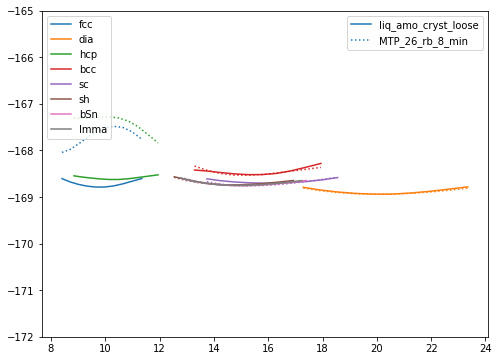

In [14]:
styl_list=['-','--','-.',':', (0, (3,6,3,6,3,10)), '-', '--', '-.', ':', ':', '--', '--', ':', ':']
df = Si_Cryst.df
cols = []
fig, axs = plt.subplots(figsize=(8,6))
for i in range(len(df['Structure'])):
    if i in []:
        continue
    line, = axs.plot(df['Volumes'][i], df[df.columns[3]][i], label=df.index[i])
    cols.append(df.columns[3][:-2])
    if i == 0:
        hands = [line]
    for j, val in enumerate(df.keys()):
        if val[-2:] == '_V' and j >= 6:
            if 'snap_shift' in val:
                pass
            else:
                tmp, = axs.plot(df[df.columns[j]][i], df[df.columns[j+1]][i], linestyle=styl_list[j-3], color=line.get_color())
                cols.append(val[:-2])
            if i == 0:
                hands.append(tmp)
l1 = axs.legend(loc='upper left')
axs.legend()
l2 = axs.legend(hands, cols, loc='upper right')
# axs.set(ylim=(-169, -168))
axs.set(ylim=(-172, -165))
axs.add_artist(l1)

In [220]:
Si_Cryst.df.head(1)

,Structure,Volumes,liq_amo_cryst_loose_V,liq_amo_cryst_loose_E,liq_amo_0.75loose_V,liq_amo_0.75loose_E,H(P) liq_amo_cryst_loose,H(P) liq_amo_0.75loose,P
fcc,"(Atom('Si', [4.976860425487557e-14, 1.40406380...","[8.406153645561451, 8.704569594210222, 9.00996...","[8.406153645561451, 8.704569594210222, 9.00996...","[-168.60516057829332, -168.6761871089022, -168...","[8.495818684515855, 8.797417715319487, 9.10607...","[-168.53713282566392, -168.60333813051116, -16...","[-168.78904694482554, -168.72703457429606, -16...","[-168.55014483399114, -168.45867309901834, -16...","[0.0, 1.0135135135135136, 2.027027027027027, 3..."


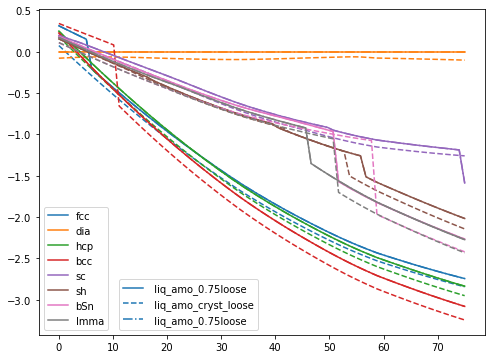

In [229]:
styl_list=['-','--','-.',':', (0, (3,6,3,6,3,10))]
df = Si_Cryst.df
cols = []
fig, axs = plt.subplots(figsize=(8,6))
for i in range(len(df['Structure'])):
    if i in []:
        continue
    line, = axs.plot(df['P'][i], df[df.columns[-2]][i] - df[df.columns[-2]]['dia'], label=df.index[i])
    cols.append(df.columns[-2][4:])
    if i == 0:
        hands = [line]

    ct = 0
    for j, val in enumerate(df.keys()):
        if 'H(P)' in val and j >= 4:
            ct += 1
            tmp, = axs.plot(df['P'][i], df[df.columns[j]][i]- df[df.columns[-2]]['dia'], linestyle=styl_list[ct], color=line.get_color())
            cols.append(val[4:])
            if i == 0:
                hands.append(tmp)
l1 = axs.legend(loc='lower left')
axs.legend()
l2 = axs.legend(hands, cols, loc='lower left', bbox_to_anchor=(0.17, 0.0))
#axs.set(ylim=(-169, -168))
axs.add_artist(l1)

In [113]:
c = read_castep_castep('/home/joe/Documents/Ge_od/Structure_databases/crystals/Si_crystals_DFT/geom/diamond_geom.castep')

In [31]:
d = read_castep_castep('//home/joe/Documents/Ge_od/Structure_databases/dia_Evol_first/CASTEP/dia.castep')

Using new read_Castep


/home/joe/ase/ase/calculators/castep.py:897: UserWarning: No regular end found in //home/joe/Documents/Ge_od/Structure_databases/dia_Evol_first/CASTEP/dia.castep file. None
  warnings.warn('No regular end found in %s file. %s' % (castep_file, self._error))


In [36]:
c[0].calc._warnings

[]

In [10]:

from ase.calculators.castep import Castep


In [14]:
calc = Castep()

In [39]:
[c[0]]

[Atoms(symbols='Si8', pbc=True, cell=[5.4322234, 5.4322234, 5.4322234], initial_magmoms=..., calculator=Castep(...))]

In [101]:
c[0].set_calculator(pots[2])

In [102]:
c[0].get_stress()

array([ 0.21632,  0.21632,  0.21632, -0.     , -0.     , -0.     ])

In [107]:
c[0].set_cell([5.44, 5.44, 5.40])

In [104]:
c[0].get_cell()

Cell([5.44, 5.44, 5.4])

In [105]:
c[0].get_stress(include_ideal_gas=False)

array([ 0.34104,  0.34104,  0.87072,  0.07879,  0.07879, -0.34307])

In [109]:
for i in range(20):
    c[0].set_cell(np.array([5.44, 5.44, 5.44])*(1+i/100))
    print(c[0].get_stress())

[-0.19598 -0.19598 -0.19598  0.07824  0.07824  0.07824]
[-2.94113 -2.94113 -2.94113  0.55338  0.55338  0.55338]
[-5.40834 -5.40834 -5.40834  0.93631  0.93631  0.93631]
[-7.57342 -7.57342 -7.57342  1.26388  1.26388  1.26388]
[-9.48317 -9.48317 -9.48317  1.54092  1.54092  1.54092]
[-11.26924 -11.26924 -11.26924   1.74449   1.74449   1.74449]
[-13.00014 -13.00014 -13.00014   1.90817   1.90817   1.90817]
[-14.65586 -14.65586 -14.65586   2.00861   2.00861   2.00861]
[-16.1835  -16.1835  -16.1835    2.08213   2.08213   2.08213]
[-17.53441 -17.53441 -17.53441   2.03102   2.03102   2.03102]
[-17.91931 -17.91931 -17.91931   1.69317   1.69317   1.69317]
[-18.65981 -18.65981 -18.65981   1.58379   1.58379   1.58379]
[-19.19049 -19.19049 -19.19049   1.45073   1.45073   1.45073]
[-19.69254 -19.69254 -19.69254   1.31333   1.31333   1.31333]
[-20.14085 -20.14085 -20.14085   1.1668    1.1668    1.1668 ]
[-19.37568 -19.37568 -19.37568   0.91484   0.91484   0.91484]
[-19.72135 -19.72135 -19.72135   0.763

In [24]:
DFT_struct[0].set_calculator(snap_test)

In [11]:
copy_structs = [deepcopy(DFT_struct[0])]
for ct, val in enumerate(copy_structs):
    if True and ct < 8:
        val.set_calculator(snap_test)
        print('pot set')
        val.set_constraint(FixSymmetry(val))
        uf = StrainFilter(val)
        opt = BFGS(uf, trajectory='MTP_test.traj')
        opt.run(0.05, steps=50)
        val.set_calculator(None)

pot set
      Step     Time          Energy         fmax
BFGS:    0 12:25:57     -152.177096       69.7714
BFGS:    1 12:25:57     -209.046499      516.3118
BFGS:    2 12:25:57     -519.158330     3581.6417
BFGS:    3 12:25:57    -1602.561136     7798.5796
BFGS:    4 12:25:57    -8389.742155    47094.8928


/home/joe/ase/ase/spacegroup/symmetrize.py:217: UserWarning: FixSymmetry adjust_cell may be ill behaved with large deformation gradient step 0.15891118497923473
  warnings.warn('FixSymmetry adjust_cell may be ill behaved with'
/home/joe/ase/ase/spacegroup/symmetrize.py:217: UserWarning: FixSymmetry adjust_cell may be ill behaved with large deformation gradient step 0.15142726911616045
  warnings.warn('FixSymmetry adjust_cell may be ill behaved with'
/home/joe/ase/ase/spacegroup/symmetrize.py:217: UserWarning: FixSymmetry adjust_cell may be ill behaved with large deformation gradient step 0.2293819686966998
  warnings.warn('FixSymmetry adjust_cell may be ill behaved with'


RuntimeError: FixSymmetry adjust_cell does not work properly with large deformation gradient step 0.2933145750426954 > 0.25

In [1]:
os.getcwd()

NameError: name 'os' is not defined

In [123]:
MTP('/home/joe/Documents/Ge_od/Potentials/Si_myDB_supercrystals/MTP/Si_myDB_liqamocryst_train_24_rb_12.mtp', potential_name='MTP_24_rb_12')

In [48]:
snap_test = SNAP({'Si':1}, potential_seed="/home/joe/Documents/Ge_od/Potentials/SNAP_pots/litDB_full_costbased_paper/Si_pot",
                 potential_name='snap_test')

In [35]:
dir(snap_test)


['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_deprecated',
 '_deprecated_get_spin_polarized',
 '_directory',
 'atoms',
 'band_structure',
 'calculate',
 'calculate_numerical_forces',
 'calculate_numerical_stress',
 'calculate_properties',
 'calculation_required',
 'check_state',
 'default_parameters',
 'directory',
 'discard_results_on_any_change',
 'export_properties',
 'get_atoms',
 'get_charges',
 'get_default_parameters',
 'get_dipole_moment',
 'get_forces',
 'get_magnetic_moment',
 'get_magnetic_moments',
 'get_potential_energies',
 'get_potential_energy',
 'get_property',
 'ge

In [36]:
snap_test.initialized

False

In [37]:
snap_test.started

False

In [49]:
DFT_struct[0].set_calculator(snap_test)
DFT_struct[0].get_potential_energy()

-152.17709636852163

In [41]:
#snap_test.lmp.close()
snap_test.restart_lammps(DFT_struct[4])

In [52]:
DFT_struct[5].calc = snap_test

In [53]:
DFT_struct[5].get_forces()

array([[-1.04196247e-13, -3.58028448e-04,  1.55331303e-12],
       [ 1.00972887e-13,  3.58028448e-04, -1.54719293e-12]])

In [1]:
snap_test.atoms


NameError: name 'snap_test' is not defined

In [23]:
snap_test.__dict__

{'potential_seed': '/home/joe/Documents/Ge_od/Potentials/SNAP_pots/litDB_full_costbased_paper/Si_pot',
 'name': 'snap_test',
 'atoms': None,
 'results': {},
 'parameters': {'atom_types': {'Si': 1},
  'atom_type_masses': None,
  'log_file': None,
  'lammps_name': '',
  'keep_alive': True,
  'lammps_header': ['units metal',
   'atom_style atomic',
   'atom_modify map array sort 0 0'],
  'amendments': None,
  'boundary': True,
  'create_box': True,
  'create_atoms': True,
  'read_molecular_info': False,
  'comm': None,
  'lmpcmds': ['pair_style hybrid/overlay zbl 4.0 4.8 snap',
   'pair_coeff * * zbl 0.0 0.0',
   'pair_coeff 1 1 zbl 14 14',
   'pair_coeff * * snap /home/joe/Documents/Ge_od/Potentials/SNAP_pots/litDB_full_costbased_paper/Si_pot.snapcoeff /home/joe/Documents/Ge_od/Potentials/SNAP_pots/litDB_full_costbased_paper/Si_pot.snapparam Si']},
 '_directory': '.',
 'prefix': None,
 'get_spin_polarized': <bound method Calculator._deprecated_get_spin_polarized of <snap.SNAP object at 0

In [33]:
DFT_struct[0]

Atoms(symbols='Si', pbc=True, cell=[[-1.676685, 1.676685, 1.287674], [1.676685, -1.676685, 1.287674], [1.676685, 1.676685, -1.287674]], initial_magmoms=..., calculator=Castep(...))